In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine,inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
#inspect hawaii.sqlite file
#inspector=inspect(engine)
#inspector.get_table_names()

# reflect an existing database into a new model
Base=automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station=Base.classes.station
Measurement=Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
#find the column names
inspector=inspect(engine)
columns=inspector.get_columns('measurement')
for column in columns:
    print(column['name'],column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Find the most recent date in the data set.
latestDate=session.query(Measurement).order_by(Measurement.date.desc()).first().date
print(f"{latestDate} is the most recent date in the data set.")

2017-08-23 is the most recent date in the data set.


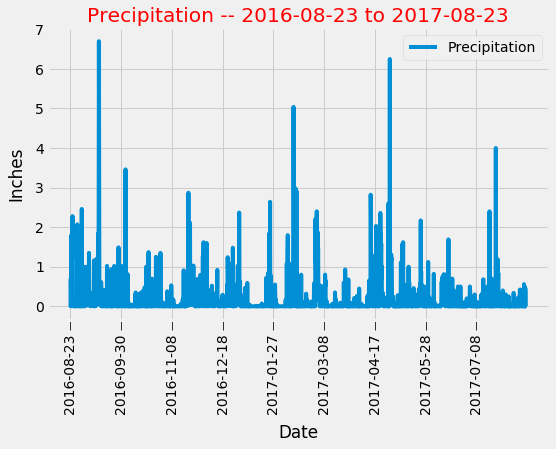

<Figure size 432x288 with 0 Axes>

In [11]:
##### Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

oneYearAgoDate=dt.date(2017,8,23)-dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
oneYearPrec=session.query(Measurement.date,Measurement.prcp)\
.filter(Measurement.date>=oneYearAgoDate).order_by(Measurement.date.desc())

# Save the query results as a Pandas DataFrame and set the index to the date column

prec_df=pd.DataFrame(oneYearPrec)
prec_df.set_index('date',inplace=True)

# Sort the dataframe by date

prec_df.sort_values('date',inplace=True)
prec_df.rename(columns={'prcp':'Precipitation'},inplace=True)
prec_df.dropna(inplace=True)


# Use Pandas Plotting with Matplotlib to plot the data

col_length=len(prec_df.iloc[::])#finds the length for the x-axis
col_div=int(round(col_length/9,0)) #finds the number to divide into col_length to get 9 ticks

ax=prec_df.plot(kind="line",rot='vertical',figsize=(8,5))#plots the graph

ax.set_xticks(range(0,col_length,1)[::col_div])#sets the xticks divided into 9 places
ax.set_xticklabels(prec_df.index[::col_div], rotation='vertical')#sets they x label into 9 places

#formats the graph
ax.set_ylabel("Inches",labelpad=10)
ax.set_xlabel("Date",labelpad=10)
ax.set_title(f"Precipitation -- {oneYearAgoDate} to {latestDate}",color='red')
ax.xaxis.set_tick_params(length=10)

plt.show()
plt.tight_layout()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
total_rain=round(np.sum(prec_df['Precipitation']),2)
mean_rain=round(np.mean(prec_df['Precipitation']),2)
median_rain=round(np.median(prec_df['Precipitation']),2)
std_rain=round(np.std(prec_df['Precipitation']),2)
min_rain=np.min(prec_df['Precipitation'])
#quartile1=prec_df.quantile(.25)
#quartile2=prec_df.quantile(.50)
#quartile3=prec_df.quantile(.75)
max_rain=np.max(prec_df['Precipitation'])

#prints the summary
print()
print(f"Precipitation from {oneYearAgoDate}-{latestDate}")
print('----------------------------------------')
print(f"total:  {total_rain}")
print(f"mean:  {mean_rain}")
print(f"median:  {median_rain}")
print(f"std:  {std_rain}")
print(f"min:  {min_rain}")
#print(f"25%:  {quartile1[0]}")
#print(f"50%:  {quartile2[0]}")
#print(f"75%:  {quartile3[0]}")
print(f"max:  {max_rain}")
print()


Precipitation from 2016-08-23-2017-08-23
----------------------------------------
total:  358.28
mean:  0.18
median:  0.02
std:  0.46
min:  0.0
max:  6.7



In [13]:
#find the column names
columns=inspector.get_columns('station')
for column in columns:
    print(column['name'],column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
# Design a query to calculate the total number stations in the dataset
stationCount=session.query(Station.station).distinct().count()
print(f"There are {stationCount} stations in the data set.")

There are 9 stations in the data set.


In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

ActiveStations=session.query(func.count(Measurement.id),Measurement.station)\
    .group_by('station').order_by(func.count(Measurement.id).desc()).all()

#print out results

print()
print('Most Active Stations')
print('--------------------')
ActiveStations



Most Active Stations
--------------------


[(2772, 'USC00519281'),
 (2724, 'USC00519397'),
 (2709, 'USC00513117'),
 (2669, 'USC00519523'),
 (2612, 'USC00516128'),
 (2202, 'USC00514830'),
 (1979, 'USC00511918'),
 (1372, 'USC00517948'),
 (511, 'USC00518838')]

In [46]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_temps=session.query(func.min(Measurement.tobs),\
    func.max(Measurement.tobs),func.avg(Measurement.tobs)).all()
print()
print(f"Station {ActiveStations[0][1]} (most active station)")
print('----------------------------------------')
print(f"Min Temperature: {most_active_temps[0][0]}")
print(f"Max Temperature: {most_active_temps[0][1]}")
print(f"AVG Temperature: {round(most_active_temps[0][2],2)}")
print()


Station USC00519281 (most active station)
----------------------------------------
Min Temperature: 53.0
Max Temperature: 87.0
AVG Temperature: 73.1



Text(0.5, 1.0, 'USC00519281 -- 2016-08-23 to 2017-08-23')

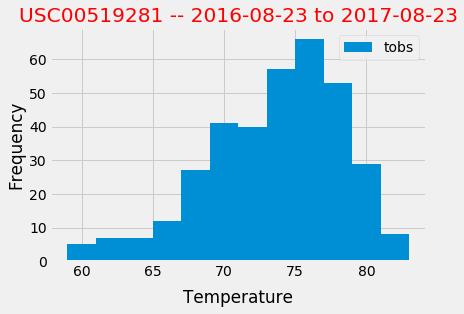

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
activeOneYearTemp=session.query(Measurement.date,Measurement.tobs)\
    .filter(Measurement.station==ActiveStations[0][1]).filter(Measurement.date>=oneYearAgoDate)\
    .filter(Measurement.date<=latestDate).all()

#turn query into pandas data frame
activeOneYearTemp_df=pd.DataFrame(activeOneYearTemp)
activeOneYearTemp_df.set_index('date',inplace=True)

#plot information
ax=activeOneYearTemp_df.plot(kind='hist',bins=12)
ax.set_xlabel("Temperature",labelpad=10)
ax.set_title(f"{ActiveStations[0][1]} -- {oneYearAgoDate} to {latestDate}",color='red')



# Close session

In [180]:
# Close Session
session.close()

In [57]:
b=session.query(Measurement.date,Measurement.prcp).all()
my_dict={}
for date, prcp in b:
    my_dict[date]=prcp

my_dict

{'2010-01-01': 0.14,
 '2010-01-02': 0.0,
 '2010-01-03': 0.0,
 '2010-01-04': 0.0,
 '2010-01-06': 0.36,
 '2010-01-07': 0.3,
 '2010-01-08': 0.0,
 '2010-01-09': 0.0,
 '2010-01-10': 0.01,
 '2010-01-11': 0.14,
 '2010-01-12': 0.0,
 '2010-01-14': 0.0,
 '2010-01-15': 0.0,
 '2010-01-16': 0.0,
 '2010-01-17': 0.0,
 '2010-01-18': 0.0,
 '2010-01-19': 0.0,
 '2010-01-20': 0.0,
 '2010-01-21': 0.32,
 '2010-01-22': 0.0,
 '2010-01-23': 0.0,
 '2010-01-24': 0.01,
 '2010-01-25': 0.0,
 '2010-01-26': 0.03,
 '2010-01-27': 0.31,
 '2010-01-28': 0.07,
 '2010-01-30': 0.33,
 '2010-01-31': 1.1,
 '2010-02-01': 0.01,
 '2010-02-03': 0.67,
 '2010-02-04': 0.0,
 '2010-02-05': 0.09,
 '2010-02-06': 0.04,
 '2010-02-07': 0.0,
 '2010-02-08': 0.0,
 '2010-02-09': 0.0,
 '2010-02-11': 0.0,
 '2010-02-12': 0.65,
 '2010-02-13': 0.62,
 '2010-02-14': 0.02,
 '2010-02-15': 0.0,
 '2010-02-16': 0.0,
 '2010-02-17': 0.02,
 '2010-02-19': 0.42,
 '2010-02-20': 0.55,
 '2010-02-21': 0.0,
 '2010-02-22': None,
 '2010-02-23': 0.0,
 '2010-02-24': 0.0,